# Potato Disease Classification

## Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Set all the Constants

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Rice_Leaf_Disease_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7420 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[4 4 3 0 4 3 2 0 3 0 2 4 2 0 0 4 4 1 2 1 4 4 1 2 0 1 4 2 3 1 1 0 4 0 3 2 1
 1 4 0 3 4 2 2 3 3 0 2 3 3 4 0 0 0 0 1 1 1 2 1 3 4 3 4]


## Visualize some of the images from our dataset

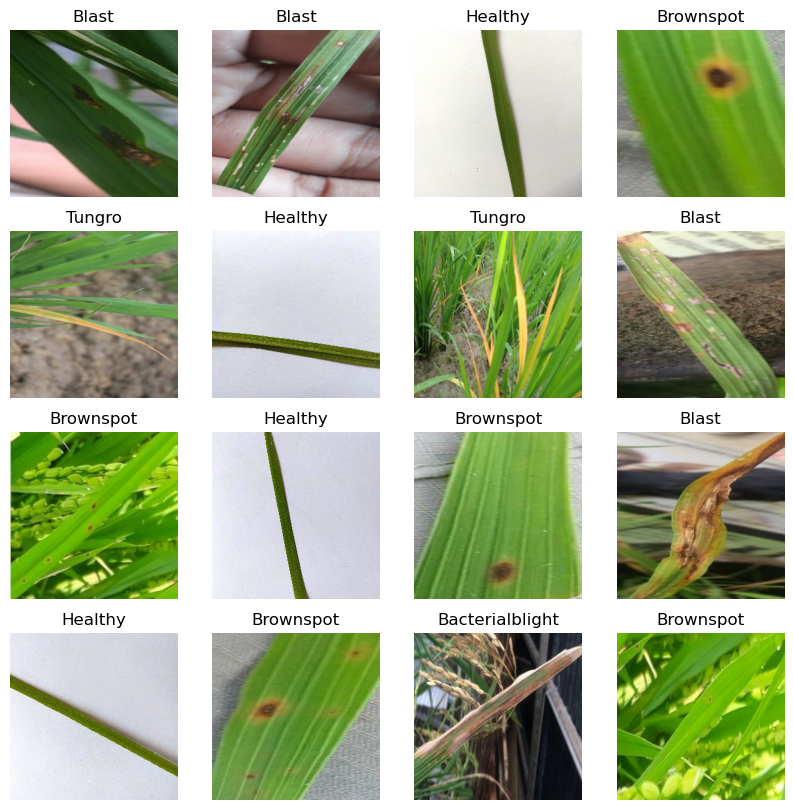

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

    1. Training: Dataset to be used while training
    2. Validation: Dataset to be tested against while training
    3. Test: Dataset to be tested against after we trained a model


In [13]:
len(dataset)

116

In [14]:
train_size = 0.8
len(dataset)*train_size

92.80000000000001

In [15]:
train_ds = dataset.take(92)
len(train_ds)

92

In [16]:
test_ds = dataset.skip(92)
len(test_ds)

24

In [17]:
val_size=0.1
len(dataset)*val_size

11.600000000000001

In [18]:
val_ds = test_ds.take(11)
len(val_ds)

11

In [19]:
test_ds = test_ds.skip(11)
len(test_ds)

13

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

92

In [23]:
len(val_ds)

11

In [24]:
len(test_ds)

13

## Cache, Shuffle, and Prefetch the Dataset

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [27]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (64, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 60, 60, 64)         

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
92/92 [==============================] - 110s 621ms/step - loss: 1.0389 - accuracy: 0.5472 - val_loss: 0.7606 - val_accuracy: 0.7344
Epoch 2/50
92/92 [==============================] - 19s 208ms/step - loss: 0.7049 - accuracy: 0.7245 - val_loss: 0.5814 - val_accuracy: 0.7670
Epoch 3/50
92/92 [==============================] - 10s 109ms/step - loss: 0.5686 - accuracy: 0.7763 - val_loss: 0.5057 - val_accuracy: 0.7969
Epoch 4/50
92/92 [==============================] - 10s 108ms/step - loss: 0.4679 - accuracy: 0.8185 - val_loss: 0.4669 - val_accuracy: 0.7983
Epoch 5/50
92/92 [==============================] - 10s 108ms/step - loss: 0.4159 - accuracy: 0.8423 - val_loss: 0.4489 - val_accuracy: 0.8125
Epoch 6/50
92/92 [==============================] - 10s 108ms/step - loss: 0.3163 - accuracy: 0.8798 - val_loss: 0.2084 - val_accuracy: 0.9105
Epoch 7/50
92/92 [==============================] - 10s 108ms/step - loss: 0.2614 - accuracy: 0.9004 - val_loss: 0.2521 - val_accuracy: 0.899

In [32]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 44s 45ms/step - loss: 6.8588e-04 - accuracy: 1.0000


In [33]:
scores

[0.0006858760607428849, 1.0]

## Plotting the Accuracy and Loss Curves

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 92}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.038925290107727,
 0.7049261927604675,
 0.5685532093048096,
 0.4678558111190796,
 0.4158805310726166]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

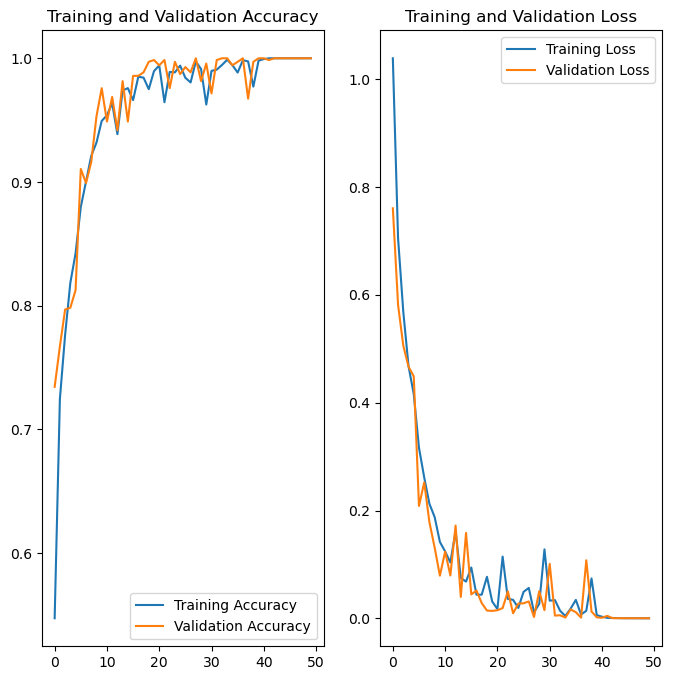

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Tungro
predicted label: Tungro


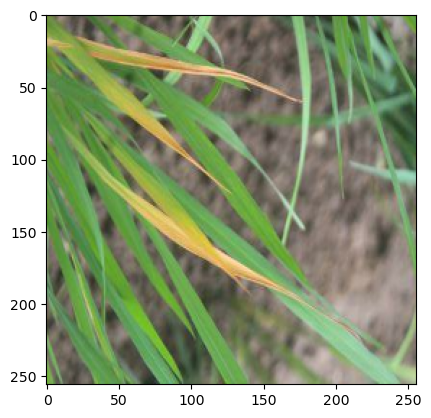

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

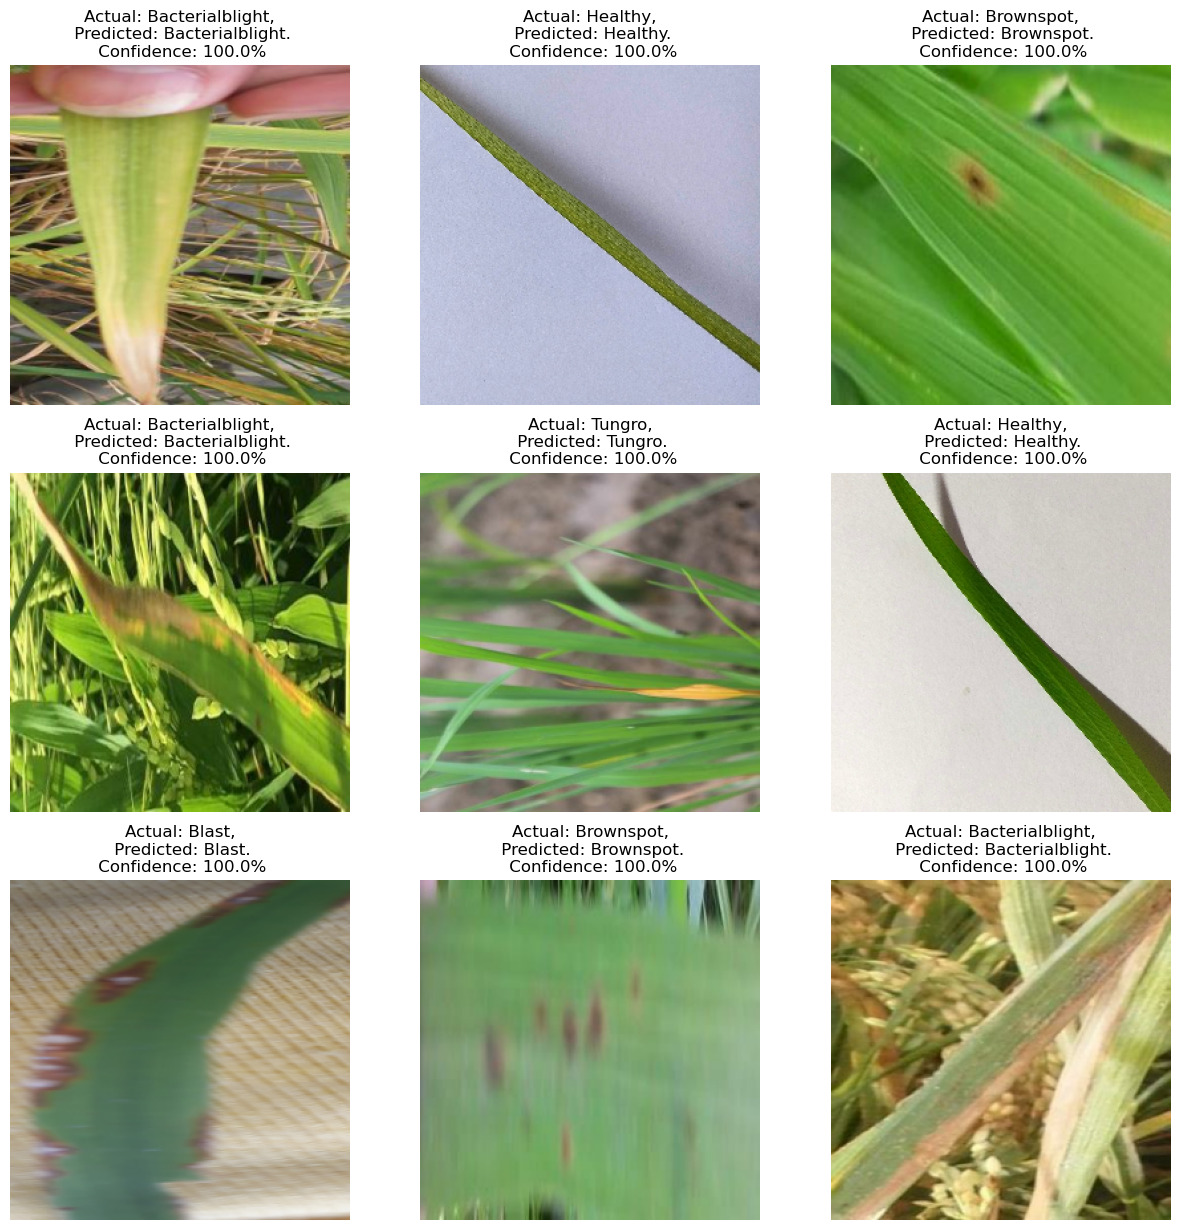

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [49]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# Load the image using the appropriate library
image_path = "C:/Users/Mosta/Downloads/index.jpg"
image = load_img(image_path, target_size=(224, 224))

# Preprocess the image
image_array = img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

# Predict the image using the model
predicted_class, confidence = predict(model, image_array, class_names)

# Print the results
print("Predicted class:", predicted_class)
print("Confidence:", confidence)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

## Saving the Model

We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")